<a href="https://colab.research.google.com/github/JSRist0028/animalmigration/blob/main/code/Compile_migration_and_weather_data_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Weather data obtained through Meteostat

Source: Meteostat.net; Raw data: NOAA, Deutscher Wetterdienst 


<a href="https://www.meteostat.net/en/sources" title="Meteostat Sources">Meteostat Sources</a>

## Animal Geolocation data obtained through MoveBank



In [ ]:
!pip install geopandas
!pip install shapely
!pip install meteostat 

     |████████████████████████████████| 1.0MB 11.9MB/s 
     |████████████████████████████████| 15.3MB 300kB/s 
     |████████████████████████████████| 6.5MB 32.6MB/s 
  Created wheel for meteostat: filename=meteostat-1.2.2-cp37-none-any.whl size=15689 sha256=1271ad247427eaa88343408c8b83b09dffa770e3b6b05f34b5e2dca8f614e408
  Stored in directory: /root/.cache/pip/wheels/bd/22/d0/1f8b9bdc0d26b89e0132a4e9d445f793a3ee13716485029415
Successfully built meteostat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import math
import datetime
import urllib.request
import json
import datetime as dt
from datetime import datetime
import csv
import codecs
import urllib.request
import sys
import matplotlib.pyplot as plt
import meteostat
from meteostat import Stations, Daily
from dateutil.relativedelta import relativedelta



## Set migration data to use (migration_data_raw) and output file (saved_csv)

In [ ]:
migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Migration timing in barnacle geese (Barents Sea) (data from Kölzsch et al. and Shariatinajafabadi et al. 2014).csv") # 4 years
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Wader migration German Wadden Sea_ grey plovers.csv") 
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Migration of Sabine's gulls from the Canadian High Arctic.csv")
#migration_data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Azores Great Whales Satellite Telemetry Program .csv")
#migration_data_raw = pd.read_csv("") 

saved_csv = "/content/drive/MyDrive/Colab Notebooks/barnacle_geese_data_matrix v2"
migration_data_raw.head()

,event-id,visible,timestamp,location-long,location-lat,ground-speed,heading,height-above-ellipsoid,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,utm-easting,utm-northing,utm-zone,study-timezone,study-local-timestamp
0,362647649,True,2009-02-10 10:00:00.000,6.10583,53.38117,0.0,51.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,307509.632577,5.918577e+06,32N,Central European Time,2009-02-10 11:00:00.000
1,362647650,True,2009-02-10 15:00:00.000,6.18700,53.39283,1.0,351.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,312958.098596,5.919658e+06,32N,Central European Time,2009-02-10 16:00:00.000
2,362647651,True,2009-02-11 10:00:00.000,6.15600,53.40483,0.0,98.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,310950.556688,5.921074e+06,32N,Central European Time,2009-02-11 11:00:00.000
3,362647652,True,2009-02-11 15:00:00.000,6.15683,53.40250,0.0,153.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,310995.384495,5.920813e+06,32N,Central European Time,2009-02-11 16:00:00.000
4,362647653,True,2009-02-12 10:00:00.000,6.13750,53.36217,0.0,61.0,1.0,gps,Branta leucopsis,78033,78033,Migration timing in barnacle geese (Barents Se...,309530.698332,5.916379e+06,32N,Central European Time,2009-02-12 11:00:00.000


In [ ]:
def date_to_nth_day(date):#, format='%Y%m%d'):
    date = pd.to_datetime(date)#, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
# source: https://codereview.stackexchange.com/questions/154140/interpret-yyyymmdd-as-the-nth-day-of-the-year

migration_data = pd.DataFrame(columns=migration_data_raw.columns)

for i, row in migration_data_raw.iterrows():
  if i>0: # skip first row
    if (date_to_nth_day(row['timestamp']) != date_to_nth_day(migration_data_raw['timestamp'][i-1])): # adds only rows that are on a different day
      migration_data = migration_data.append(row, ignore_index=True)
      #print(i)

In [ ]:
# get year
dates = pd.to_datetime(migration_data['timestamp'])
years = pd.DatetimeIndex(dates).year
years
set(years)

{2008, 2009, 2010, 2011}

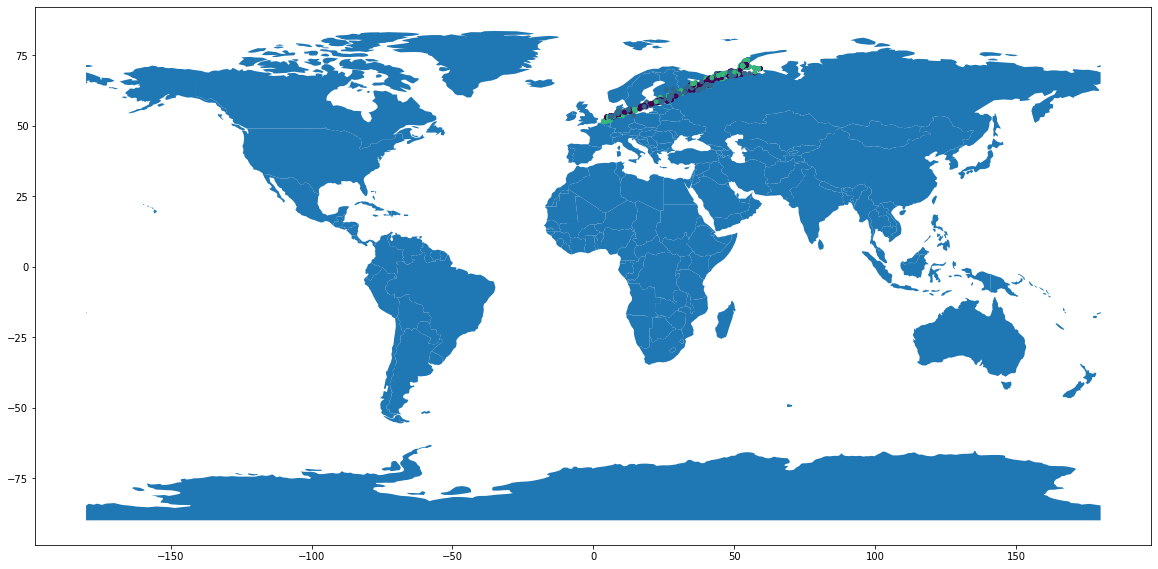

In [ ]:
geometry = [Point(xy) for xy in zip(migration_data['location-long'], migration_data['location-lat'])]
gdf = GeoDataFrame(migration_data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20,12)), marker='o', c = years, markersize=15);


In [ ]:
import csv
from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)


In [ ]:
!pip install meteostat -U

Requirement already up-to-date: meteostat in /usr/local/lib/python3.7/dist-packages (1.2.2)


In [ ]:
 from dateutil.relativedelta import relativedelta

 def getWeather(stations, lat, long, mig_datetime):
   #stations = Stations()
   stations = stations.nearby(lat = 33.52068, lon = -86.81176,radius=40000) #note: radius is in meters (40k meters ~ 25 miles)
   station = stations.fetch(1)
   weather_data = Daily(station, start=mig_datetime,end=(mig_datetime + relativedelta(days=1)))
   weather_data = weather_data.fetch()
   weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
   for i in range(2, stations.count()-1):
     if (np.isnan(weather_data_temp).any):
      station = stations.fetch(i)
      weather_data = Daily(station, start=mig_datetime,end=(mig_datetime + relativedelta(days=1)))
      weather_data = weather_data.fetch()
      #print(weather_data['wpgt'].values.tolist())
      if np.isnan(weather_data_temp[0][0]): #tavg
        [weather_data_temp[0][0]] = weather_data['tavg'].values.tolist()
      if np.isnan(weather_data_temp[0][1]): #tmin tmax
        [weather_data_temp[0][1]] = weather_data['tmin'].values.tolist()
        [weather_data_temp[0][2]] = weather_data['tmax'].values.tolist()
      if np.isnan(weather_data_temp[0][3]): #prcp
        [weather_data_temp[0][3]] = weather_data['prcp'].values.tolist()
      if np.isnan(weather_data_temp[0][4]): #snow
        [weather_data_temp[0][4]] = weather_data['snow'].values.tolist()
      if np.isnan(weather_data_temp[0][5]): #wdir
        [weather_data_temp[0][5]] = weather_data['wdir'].values.tolist()
      if np.isnan(weather_data_temp[0][6]): #wspd
        [weather_data_temp[0][6]] = weather_data['wspd'].values.tolist()
      if np.isnan(weather_data_temp[0][7]): #wpgt
        [weather_data_temp[0][7]] = weather_data['wpgt'].values.tolist()
      if np.isnan(weather_data_temp[0][8]): #pres
        [weather_data_temp[0][8]] = weather_data['pres'].values.tolist()
      if np.isnan(weather_data_temp[0][9]): #tsun
        [weather_data_temp[0][9]] = weather_data['tsun'].values.tolist()
   station_data = station.values[0]
   return [weather_data_temp, station_data]
stations = Stations()
mig_date = dt.datetime.strptime(migration_data['timestamp'][25], "%Y-%m-%d %H:%M:%S.000") 
[aa, bb]=getWeather(stations, 10,100, mig_date)
aa

[[21.0, 16.7, 26.7, 0.0, 0.0, nan, 10.4, nan, 1020.7, nan]]

In [ ]:
records = []

# Create header
header = ['row number','timestamp', 'latitude', 'longitude', 'height', 'speed', 'heading', 'birdID', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'station_lat', 'station_long']
append_list_as_row(saved_csv, header)

for i, row in migration_data.iterrows():
  if  True: #(i >= 0) & (i<10):
    latitude = row['location-lat']
    longitude = row['location-long']
    birdID = row['individual-local-identifier']
    timestamp = row['timestamp']
    speed	= row['ground-speed']
    heading	= row['heading'] 
    height = row['height-above-ellipsoid']

    if math.isnan(latitude) or math.isnan(longitude) or (latitude==0 and longitude ==0):
      print("bad coordinates {},{}".format(latitude, longitude))
      continue
    #if timestamp < start_date:
    #  print("Bad timestamp {}".format(timestamp))
    #  continue
    try:
      #datetime = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:00:00.000')
      mig_datetime = dt.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.000")  #timestamp.apply(lambda x :pd.to_datetime(str(x)))
      print(mig_datetime)
    except:
      print("Bad date format {}".format(timestamp))
      continue 

    #latitude ='{:.5f}'.format(latitude)
    #longitude = #'{:.5f}'.format(longitude)

    # Get closest weather station
    try:
      stations = Stations()
      [weather_data_temp, station_data]=getWeather(stations, latitude, longitude, mig_datetime)

    except:
      print("Trouble loading station at {}, {}, on {}".format(latitude, longitude, mig_datetime))
    #print("Successfully loaded weather data: {}".format(weather_data))
    # assemble data into matrix 
    try:
      #weather_data_temp = weather_data[['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']].values.tolist()
      #station_data = station.values[0]
      tavg_temp, tmin_temp, tmax_temp, prcp_temp, snow_temp, wdir_temp, wspd_temp, wpgt_temp, pres_temp, tsun_temp = weather_data_temp[0]
      new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID, tavg_temp, tmin_temp, tmax_temp, prcp_temp, snow_temp, wdir_temp, wspd_temp, wpgt_temp, pres_temp, tsun_temp, station_data[5], station_data[6]]
      append_list_as_row(saved_csv, new_row)
      print(i)
      #print(new_row)
    except:
      print("Problem loading weather data at {}, {} on {}".format(latitude, longitude, datetime))
      print(weather_data)
      try:
        new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID,'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', station_data[5], station_data[6]]
        append_list_as_row(saved_csv, new_row)
      except:
        new_row = [i, mig_datetime, latitude, longitude, height, speed, heading, birdID,'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
        append_list_as_row(saved_csv, new_row)
  


2009-02-11 10:00:00
0
2009-02-12 10:00:00
1
2009-02-13 10:00:00
2
2009-02-14 10:00:00
3
2009-02-15 07:00:00
4
2009-02-16 07:00:00
5
2009-02-17 10:00:00
6
2009-02-18 07:00:00
7
2009-02-19 07:00:00
8
2009-02-20 07:00:00
9
